Imports for the program can be viewed below, for personal testing on a new machine it may be required to use "pip" to install certan functions, to isntall please run as admin when using pip to avoid error with sklearn

In [63]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
from PIL.Image import open

import seaborn as sns

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras.layers import MaxPooling2D, Flatten, Dense, Conv2D
from keras.losses import BinaryCrossentropy
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD


within this block we define the variables we use in the dataset 

- IMGDataSet is the brain tumor dataset 
- the working folder is where we will store the model 
- the csv dataset is stored as CSVDataSet

we also define the height and the width of each of the images so we can use them in the CNN


In [32]:
IMGDataSet = "Brain Tumor"
workingFolder = "working"
CSVDataSet = pd.read_csv("Brain_Tumor.csv")
height = 224
width = 224

next we test the CSV file to see if its imported by calling the .head() function, we also only pass the class and image column as for now thats all we need, as we can see the file is succesfully passed and the dataset is present. 

In [33]:
CSVDataSet.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


the class and image columns are then checked for null values to remove error from the code 

In [34]:
CSVDataSet.isna().sum()

Image                 0
Class                 0
Mean                  0
Variance              0
Standard Deviation    0
Entropy               0
Skewness              0
Kurtosis              0
Contrast              0
Energy                0
ASM                   0
Homogeneity           0
Dissimilarity         0
Correlation           0
Coarseness            0
dtype: int64

After this the "Class" column from the csv dataset is plotted as a bar chart to show us the split between each of the values within. This shows us the tumor to non tumor spread.

C:\Users\ethan\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Class', ylabel='count'>

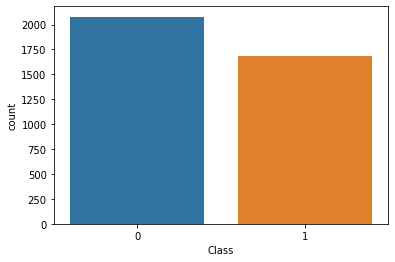

In [35]:
sns.countplot(CSVDataSet["Class"])

To show the dataset in its interiaty we take a random sub sample of the images within the data to display, this is done randomly and shows a mic of tumor and non tumor 

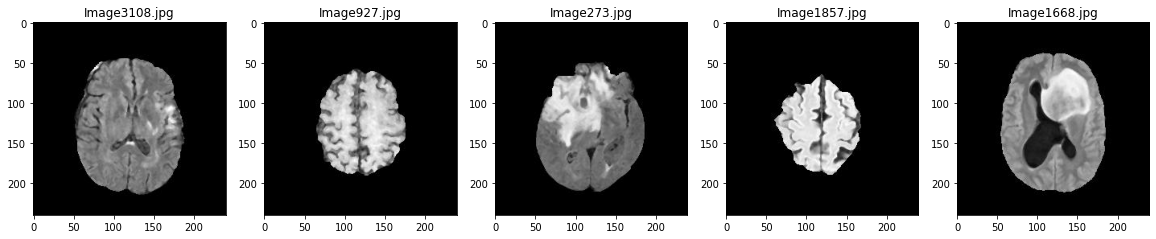

In [36]:
# creates a plot
plt.figure(figsize=(20,20))
# creates a loop to run thrugh dataset 
for i in range(5):
    file = random.choice(os.listdir(IMGDataSet))
    image_path= os.path.join(IMGDataSet, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

Next we create a dataframe wiht the image and class columns from the CSV and populate the dataframe similarly to the CSV

In [37]:
dataframe = pd.DataFrame()
dataframe["Image"] = CSVDataSet["Image"]
dataframe["Class"] = CSVDataSet["Class"]

path_list = []

for img_path in os.listdir(IMGDataSet):
    path_list.append( os.path.join(IMGDataSet,img_path))
    
pathTemp = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}

dataframe["paths"] = CSVDataSet["Image"].map(pathTemp.get)

dataframe.head()

,Image,Class,paths
0,Image1,0,Brain Tumor\Image1.jpg
1,Image2,0,Brain Tumor\Image2.jpg
2,Image3,1,Brain Tumor\Image3.jpg
3,Image4,1,Brain Tumor\Image4.jpg
4,Image5,0,Brain Tumor\Image5.jpg


In [38]:
dataframe['pixels']=dataframe['paths'].map(lambda x:np.asarray(open(x).resize((height,width))))
dataframe.head()

,Image,Class,paths,pixels
0,Image1,0,Brain Tumor\Image1.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,Brain Tumor\Image2.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,Brain Tumor\Image3.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,Brain Tumor\Image4.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,Brain Tumor\Image5.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [39]:
image_list = []
for i in range(len(dataframe)):
    brain_image = dataframe["pixels"][i].astype(np.float32)
    brain_image /= 255
    image_list.append(brain_image)
X = np.array(image_list)

print(X.shape)

(3762, 224, 224, 3)


In [40]:
y = np.array(dataframe.Class)
y.shape

(3762,)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(X_train.shape[0]))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(X_test.shape[0]))

The shape of the X_train : (2633, 224, 224, 3)
The size of the X_train : 2633
The shape of the X_test : (1129, 224, 224, 3)
The size of the X_test: 1129


In [65]:
def model(input_shape):
    
    model = Sequential()
    
    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
            
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(1, activation="sigmoid")) 
    
    
    return model

In [66]:
model = model(input_shape = (height, width, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 112, 112, 16)      448       
                                                                 
 conv2d_13 (Conv2D)          (None, 56, 56, 16)        2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                  

In [67]:
optimizer = SGD(learning_rate=0.01)
loss_fn = BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [68]:
# Training the model
history = model.fit(x=X_train, y=y_train, epochs=40, batch_size=10)

Epoch 1/40


C:\Users\ethan\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [46]:
model.save("working/MODEL_SAVE")

INFO:tensorflow:Assets written to: working/MODEL_SAVE\assets


In [47]:
eval_score = model.evaluate(X_test, y_test)

print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

C:\Users\ethan\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 2s 48ms/step - loss: 0.1589 - accuracy: 0.9539
Test loss: 0.1589198261499405
Test accuracy: 0.9539415240287781


In [48]:
y_pred_CNN = (model.predict(X_test) > 0.5).astype("int32")
print(y_pred_CNN)

[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


<AxesSubplot:>

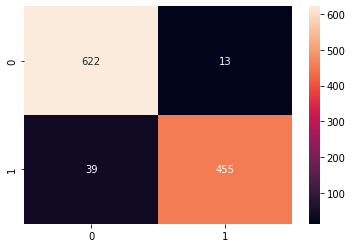

In [49]:
CM = confusion_matrix(y_test,y_pred_CNN)
sns.heatmap(CM, annot=True,fmt="g")

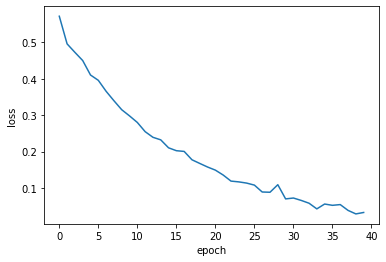

In [50]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

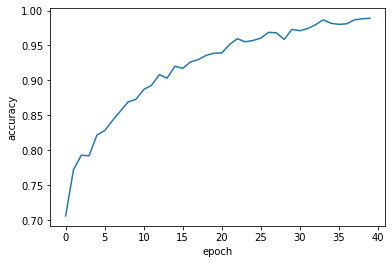

In [51]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

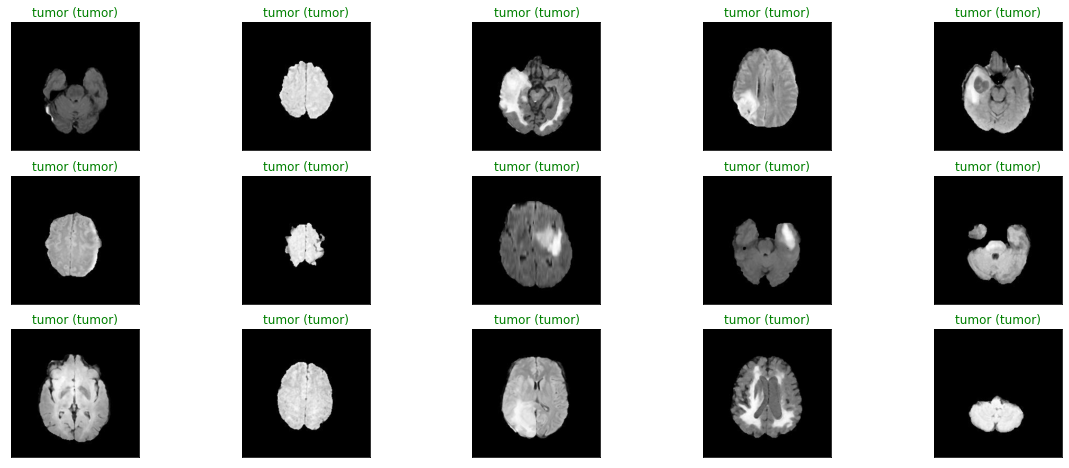

In [52]:
# Define the text class labels
labels = ["tumor", "tumor free"]

test_model = model.predict(X_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(test_model[index])
    true_index = np.argmax(y_test[index])
    image_path= os.path.join(IMGDataSet, file)
    # Set the title for each image
    ax.set_title("{} ({})".format(
                                    labels[predict_index], 
                                    labels[true_index]),
                                    color=("green" if predict_index == true_index else "red"))

In [53]:
data = pd.read_csv("Brain_Tumor.csv")
data = data.drop("Coarseness", axis=1)

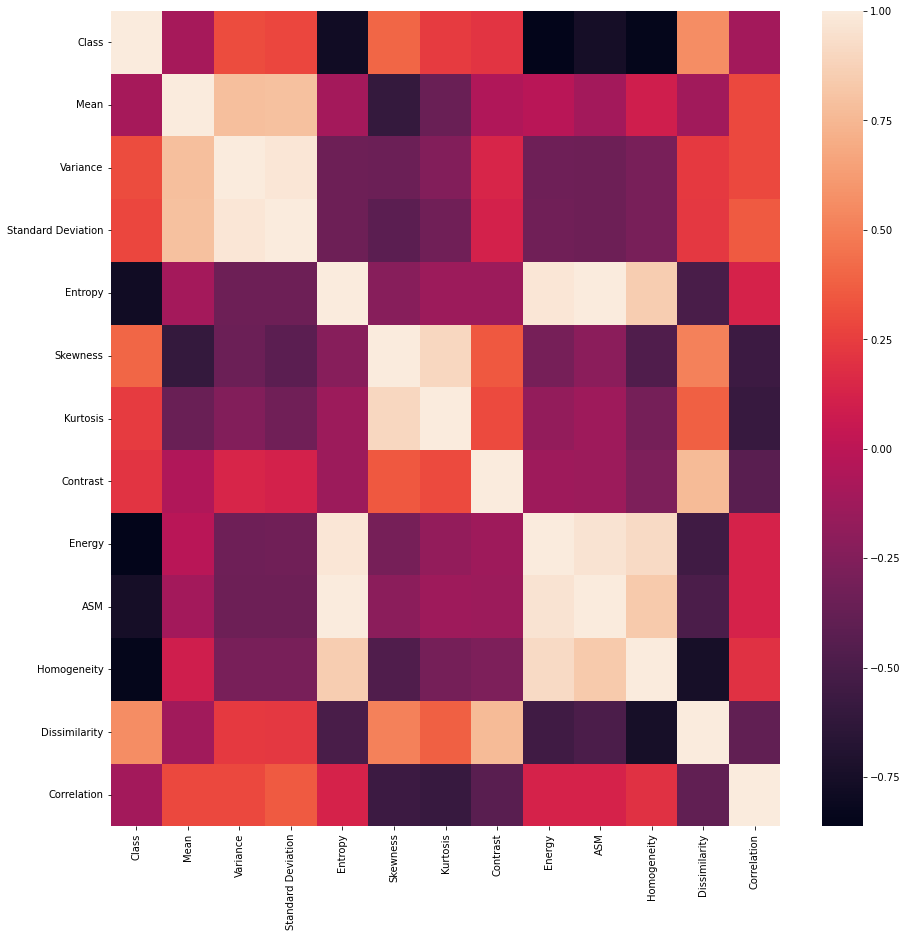

In [54]:
data.head()
data.isnull()
plt.figure(figsize = (15,15))
sns.heatmap(data.corr())
plt.show ()
correlation = abs(data.corr()["Class"].sort_index()).reset_index().rename(columns= {"index":"feature"})

In [55]:
correlation.sort_values("Class", ascending = False)
finfeatures = correlation[correlation['Class']>0.4].feature.to_numpy()

In [56]:
final_features = data[finfeatures]
final_features.head()

,ASM,Class,Dissimilarity,Energy,Entropy,Homogeneity,Skewness
0,0.086033,0,4.473346,0.293314,0.109059,0.530941,4.276477
1,0.225674,0,3.220072,0.475051,0.266538,0.651352,3.718116
2,0.001019,1,5.981800,0.031917,0.001467,0.268275,5.061750
3,0.001026,1,7.700919,0.032024,0.001477,0.243851,5.677977
4,0.118232,0,6.834689,0.343849,0.146761,0.501140,4.283221


<AxesSubplot:>

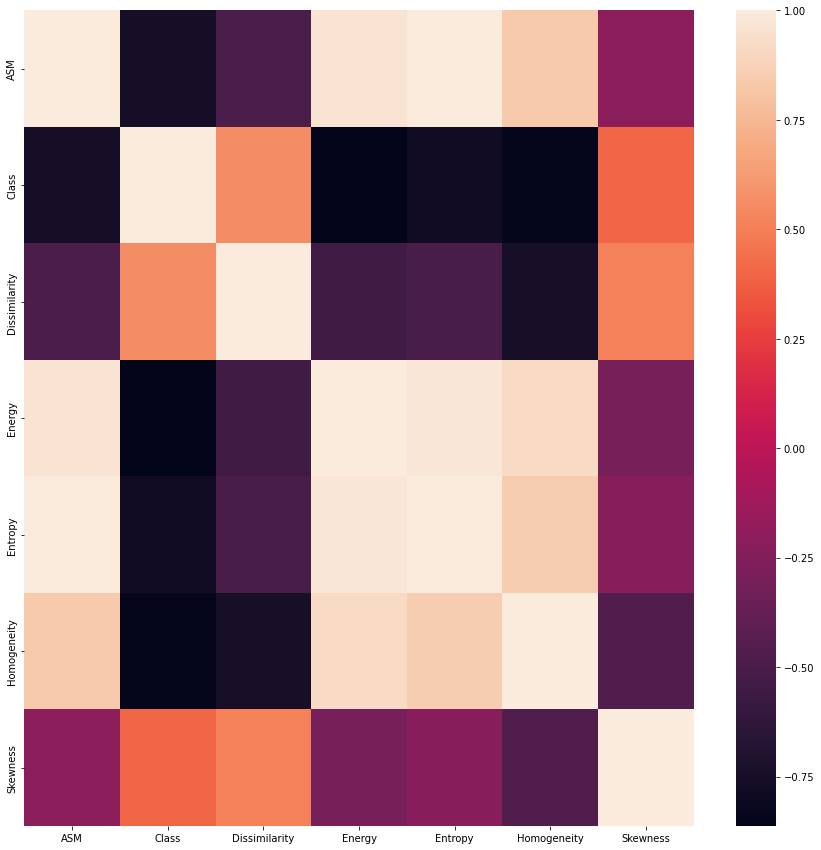

In [57]:
plt.figure(figsize =(15,15))
sns.heatmap(final_features.corr())

In [58]:

x = final_features.drop('Class',axis=1).to_numpy()
y = final_features['Class'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1) 

In [59]:
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.transform(x_test)

In [60]:
DTC_GS = tree.DecisionTreeClassifier()
BC_GS = BaggingClassifier(DTC_GS)

In [61]:
E1_param_grid_1 = [{'n_estimators': [100,200,300,500,800,1200],
               'min_samples_split': [2, 5, 10, 15, 100],
               'max_depth': [10, 20, 30]}]

In [62]:
CV_RFC = GridSearchCV(DTC_GS,E1_param_grid_1, cv= 5, n_jobs=-1)
CV_RFC.fit(x_train_std, y_train)
CV_RFC.best_params_

ValueError: Invalid parameter n_estimators for estimator DecisionTreeClassifier(max_depth=10). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
E1_bestparam1 = CV_RFC.best_params_['n_estimators']
E1_bestparam2 = CV_RFC.best_params_['min_samples_split']
E1_bestparam3 = CV_RFC.best_params_['max_depth']

In [ ]:
E1_param_grid_2 = [{ 'learning_rate' : [1,1.1,1.2,1.3,1.4,1.5]}]


In [ ]:
CV_ADA = GridSearchCV(BC_GS,E1_param_grid_2, cv= 5, n_jobs=-1)
CV_ADA.fit(x_train_std, y_train)
CV_ADA.best_params_

In [ ]:
E1_bestparam4 = CV_ADA.best_params_['learning_rate']


In [ ]:
DTC = tree.DecisionTreeClassifier(n_estimators= E1_bestparam1, min_samples_split= E1_bestparam2, max_depth = E1_bestparam3)
ABC = BaggingClassifier(DTC,learning_rate=E1_bestparam4)
ABC.fit( x_train_std, y_train)

In [ ]:
scores = cross_val_score(ABC, x_test_std, y_test, cv=2)

In [ ]:
scores.mean()
y_pred_ensemble = BC.predict(x_test_std)
cf = confusion_matrix(y_test,y_pred_ensemble)
sns.heatmap(cf, annot=True,fmt ='g')